In [ ]:
本章介绍如何使用 TensorFlow 快速搭建动态模型。

模型的构建： tf.keras.Model 和 tf.keras.layers

模型的损失函数： tf.keras.losses

模型的优化器： tf.keras.optimizer

模型的评估： tf.keras.metrics



## 模型和层 model & layer

在TensorFlow中，推荐使用tf.keras 构建模型
keras 有两个重要概念：模型和层
层将各种计算流程和变量进行了封装（例如基本的全连接层，CNN 的卷积层、池化层等），
而模型则将各种层进行组织和连接，并封装成一个整体，描述了如何将输入数据通过各种层以及运算而得到输出。


Keras 模型以类的形式呈现，我们可以通过继承 tf.keras.Model 这个 Python 类来定义自己的模型。
在继承类中，我们需要重写 __init__() （构造函数，初始化）和 call(input) （模型调用）两个方法，
同时也可以根据需要增加自定义的方法。

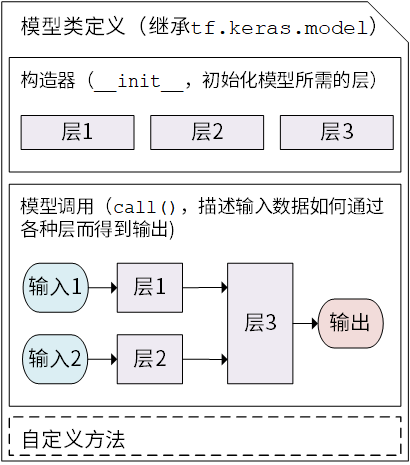

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()     # Python 2 下使用 super(MyModel, self).__init__()
        # 此处添加初始化代码（包含 call 方法中会用到的层），例如
        # layer1 = tf.keras.layers.BuiltInLayer(...)
        # layer2 = MyCustomLayer(...)

    def call(self, input):
        # 此处添加模型调用的代码（处理输入并返回输出），例如
        # x = layer1(input)
        # output = layer2(x)
        return output

    # 还可以添加自定义的方法

## 对于上一章的简单线性模型，y_pred=a*X+b ,可以通过模型类的方式编写如下：
注意，最大的区别是
这里，我们没有显式地声明 a 和 b 两个变量并写出 y_pred = a * X + b 这一线性变换，而是建立了一个继承了 tf.keras.Model 的模型类 Linear 。
这个类在初始化部分实例化了一个 全连接层 （ tf.keras.layers.Dense ），并在 call 方法中对这个层进行调用，实现了线性变换的计算。如果需要显式地声明自己的变量并使用变量进行自定义运算，或者希望了解 Keras 层的内部原理，请参考 自定义层。

In [ ]:


import tensorflow as tf

X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y = tf.constant([[10.0], [20.0]])


class Linear(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = tf.keras.layers.Dense(
            units=1,
            activation=None,
            kernel_initializer=tf.zeros_initializer(),
            bias_initializer=tf.zeros_initializer()
        )

    def call(self, input):
        output = self.dense(input)
        return output


# 以下代码结构与前节类似
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
for i in range(100):
    with tf.GradientTape() as tape:
        y_pred = model(X)      # 调用模型 y_pred = model(X) 而不是显式写出 y_pred = a * X + b
        loss = tf.reduce_mean(tf.square(y_pred - y))
    grads = tape.gradient(loss, model.variables)    # 使用 model.variables 这一属性直接获得模型中的所有变量
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
print(model.variables)